# **Multivariate Time Series Forecasting of Wheat Yield in Australia Using LSTM**

This notebook shows the code for my Final Year Project: *Utilizing the Australian Actuaries Climate Index to Predict Wheat Yield in Australia: A Comparative Analysis of Vector Autoregression and Recurrent Neural Network*

In [1]:
import os
os.getcwd()

'/home/matthewfarant123/apu-fyp'

# Data Pre-Processing

In [109]:
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import interpolate
from pandasql import sqldf

In [110]:
#Import The AACI Dataset
df = pd.read_csv('aaci_australia.csv')

In [111]:
df.head()

,Region,Year,Quarter,AACI
0,AU,1981,1,-0.360721
1,AU,1981,2,0.028828
2,AU,1981,3,-0.121666
3,AU,1981,4,0.104726
4,AU,1982,1,0.095754


In [179]:
#Unpivot the AACI data
sqlkey = lambda q : sqldf(q,globals())
query =  '''
    WITH grouped AS (
      SELECT Year,
        Region,
        AVG(AACI) AS AACI
      FROM df
      GROUP BY 1,2
    ), 
    transposed AS (
      SELECT Year,
        CASE WHEN Region = 'AU' THEN AACI END AS AU,
        CASE WHEN Region = 'CS' THEN AACI END AS CS,
        CASE WHEN Region = 'EN' THEN AACI END AS EN,
        CASE WHEN Region = 'ES' THEN AACI END AS ES,
        CASE WHEN Region = 'MB' THEN AACI END AS MB,
        CASE WHEN Region = 'MN' THEN AACI END AS MN,
        CASE WHEN Region = 'RN' THEN AACI END AS RN,
        CASE WHEN Region = 'RS' THEN AACI END AS RS,
        CASE WHEN Region = 'SE' THEN AACI END AS SE,
        CASE WHEN Region = 'ST' THEN AACI END AS ST,
        CASE WHEN Region = 'SV' THEN AACI END AS SV,
        CASE WHEN Region = 'SW' THEN AACI END AS SW,
        CASE WHEN Region = 'WT' THEN AACI END AS WT
      FROM grouped
    )
    SELECT Year,
      SUM(AU) AS AU,
      SUM(CS) AS CS,
      SUM(EN) AS CN,
      SUM(ES) AS ES,
      SUM(MB) AS MB,
      SUM(MN) AS MN,
      SUM(RN) AS RN,
      SUM(RS) AS RS,
      SUM(SE) AS SE,
      SUM(ST) AS ST,
      SUM(SV) AS SV,
      SUM(SW) AS SW,
      SUM(WT) AS WT
    FROM transposed
    GROUP BY Year
    ;
    '''
df_final = sqlkey(query)

In [180]:
df_final.head()

,Year,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT
0,1981,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143
1,1982,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190
2,1983,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916
3,1984,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922
4,1985,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531


In [ ]:
#generated using bigquery
#query:
# WITH grouped AS (
#       SELECT *
#       FROM (
#         SELECT *, ROW_NUMBER() OVER(PARTITION BY Region,Year ORDER BY abs(AACI) DESC) rn
#         FROM fyp.aaci_df
#       ) x
#       WHERE rn = 1
#     ),
# transposed AS (
# SELECT Year,
#     CASE WHEN Region = 'AU' THEN AACI END AS AU,
#     CASE WHEN Region = 'CS' THEN AACI END AS CS,
#     CASE WHEN Region = 'EN' THEN AACI END AS EN,
#     CASE WHEN Region = 'ES' THEN AACI END AS ES,
#     CASE WHEN Region = 'MB' THEN AACI END AS MB,
#     CASE WHEN Region = 'MN' THEN AACI END AS MN,
#     CASE WHEN Region = 'RN' THEN AACI END AS RN,
#     CASE WHEN Region = 'RS' THEN AACI END AS RS,
#     CASE WHEN Region = 'SE' THEN AACI END AS SE,
#     CASE WHEN Region = 'ST' THEN AACI END AS ST,
#     CASE WHEN Region = 'SV' THEN AACI END AS SV,
#     CASE WHEN Region = 'SW' THEN AACI END AS SW,
#     CASE WHEN Region = 'WT' THEN AACI END AS WT
# FROM grouped
#     )
#     SELECT Year,
#       SUM(AU) AS AU,
#       SUM(CS) AS CS,
#       SUM(EN) AS CN,
#       SUM(ES) AS ES,
#       SUM(MB) AS MB,
#       SUM(MN) AS MN,
#       SUM(RN) AS RN,
#       SUM(RS) AS RS,
#       SUM(SE) AS SE,
#       SUM(ST) AS ST,
#       SUM(SV) AS SV,
#       SUM(SW) AS SW,
#       SUM(WT) AS WT
#     FROM transposed
#     GROUP BY Year
#     ORDER BY Year
# ;
aaci = pd.read_csv('aaci_clean.csv')
aaci = aaci[(aaci != 2021)]

In [181]:
#Exclude 2021 Data
aaci = df_final[(df_final.Year != 2021)]

In [182]:
#Import the Wheat Yield Dataset
wheat = pd.read_csv('wheat_data.csv')

In [217]:
#Join the AACI and Wheat Yield Dataset
query = '''
  SELECT a.Year,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT
  FROM aaci a
  INNER JOIN wheat b
  ON a.Year = b.Year
    '''
final_data = sqlkey(query)

In [218]:
#Final Dataframe
final_data.head()

,Year,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT
0,1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143
1,1982,0.764317,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190
2,1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916
3,1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922
4,1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531


In [219]:
final_data = final_data.set_index('Year')
#final_data['Year'] = final_data.index

In [220]:
final_data.head()

,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT
Year,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143
1982,0.764317,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531


In [ ]:
final_data.to_csv()

# Data Visualization

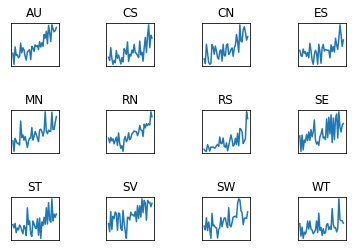

In [15]:
aaci = aaci.set_index('Year')
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
values = aaci.values
fig,sub = plt.subplots(3,4)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(aaci.columns[i])

/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


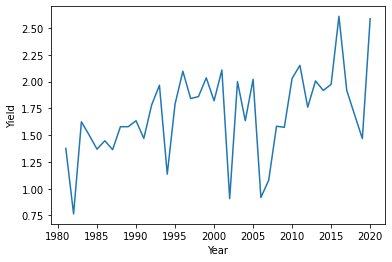

In [34]:
original = final_data[['Year', 'Yield']]
sn.lineplot(original['Year'], original['Yield'])

# Outlier Detection

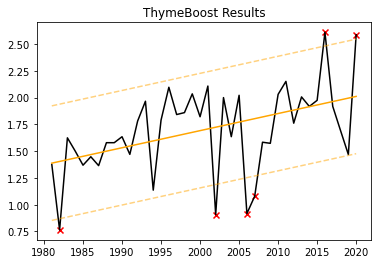

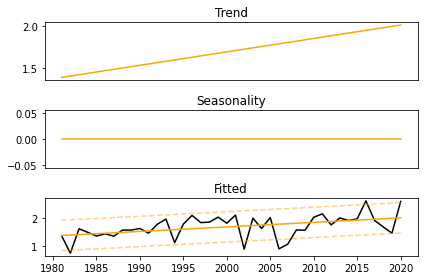

In [187]:
from ThymeBoost import ThymeBoost as tb
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(final_data['Yield'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                      #  seasonal_period=25,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
boosted_model.plot_components(output)

The result above that there IS an outlier. Hence, we need to solve this before proceeding to the modelling process

In [221]:
## Handling Outlier
final_data['Yield'].loc[1982] = np.nan
final_data['Yield'].loc[1994] = np.nan
final_data['Yield'].loc[2002] = np.nan
final_data['Yield'].loc[2006] = np.nan
final_data['Yield'].loc[2007] = np.nan
final_data['Yield'].loc[2016] = np.nan
final_data['Yield'].loc[2019] = np.nan
final_data['Yield'].loc[2020] = np.nan

In [191]:
#Linear Interpolation : final_data.interpolate().head()
#Spline Interpolation
final_data.interpolate(method='spline',order=3).head()

,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT
Year,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143
1982,1.370017,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531


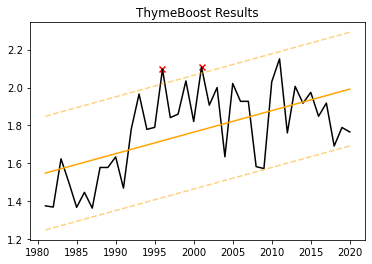

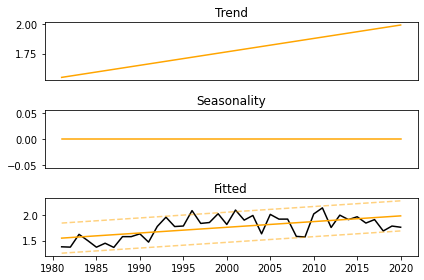

In [192]:
output = boosted_model.detect_outliers(final_data.interpolate(method='spline',order=3)['Yield'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                      #  seasonal_period=25,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
boosted_model.plot_components(output)

In [223]:
final_data = final_data.interpolate(method='spline',order=3)

# Modelling


In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
np.random.seed(100)

In [224]:
#Scaling The Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(final_data.values)
scaled[0]

array([0.01526656, 0.28248772, 0.17857399, 0.1371634 , 0.3529544 ,
       0.29232492, 0.26543629, 0.33389395, 0.05209828, 0.38868173,
       0.34833665, 0.36922657, 0.30734826, 0.36983582])

In [225]:
#Supervised form
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [226]:
timeSteps = 5

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.015267,0.282488,0.178574,0.137163,0.352954,0.292325,0.265436,0.333894,0.052098,0.388682,...,0.187217,0.195998,0.317733,0.101987,0.287069,0.261834,0.555887,0.411693,0.158119,0.105657
1,0.007030,0.000000,0.099619,0.021128,0.226343,0.329099,0.000000,0.216731,0.008627,0.000000,...,0.230045,0.205065,0.191290,0.006539,0.233713,0.214527,0.502240,0.235916,0.106141,0.000000
2,0.330059,0.441348,0.421748,0.505713,0.201788,0.627951,0.327840,0.354864,0.000000,0.411465,...,0.354843,0.160253,0.280199,0.111048,0.425007,0.336572,0.665194,0.000000,0.210788,0.272354
3,0.172753,0.225676,0.147823,0.291692,0.388828,0.151368,0.260019,0.264476,0.170584,0.036517,...,0.466177,0.768300,0.360610,0.101711,0.272410,0.297557,0.626195,0.628821,0.437086,0.272362
4,0.005365,0.246513,0.000000,0.055398,0.283253,0.187217,0.195998,0.317733,0.101987,0.287069,...,0.240962,0.348359,0.151394,0.112003,0.492073,0.195545,0.204248,0.312374,0.238992,0.343112


In [227]:
#Training and Testing Splitting
features = final_data.shape[1]
train_years = 25
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_years,:]
x_test = X[train_years:,:]
y_train = y[:train_years]
y_test = y[train_years:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25, 70) (10, 70) (25,) (10,)


In [228]:
#Convert Data Shape to Fit LSTM Model

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(25, 5, 14) (10, 5, 14)


In [229]:
#Defining the Model

model = Sequential()
model.add( LSTM( 128, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True ))
model.add( LSTM( 64, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True ))
model.add( LSTM( 32, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True))
model.add( LSTM( 16, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=False))
model.add(Dense(1))

model.compile( loss = "mse", optimizer = "adam")

history =  model.fit( x_train,y_train,
                     validation_data = (x_test,y_test),
                     epochs = 100 ,
                     batch_size = 72,
                     verbose = 0,
                     shuffle = False)

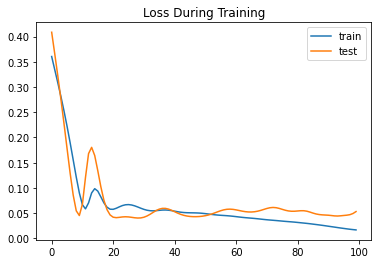

In [230]:
#Learning Curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss During Training")
plt.show()

In [231]:
#Scaling Back the Wheat Yield Data to Original Scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-13:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-13:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [232]:
#Predicted Year
df_forecast = pd.DataFrame({'Date':np.arange(start=2021-len(final_pred), stop=2021, step=1), 'Yield':final_pred})
df_forecast

,Date,Yield
0,2011,1.865295
1,2012,1.749187
2,2013,1.725617
3,2014,1.760399
4,2015,2.077521
5,2016,1.716368
6,2017,1.676338
7,2018,1.750943
8,2019,1.786257
9,2020,1.998206


In [233]:
final_data['Year'] = final_data.index

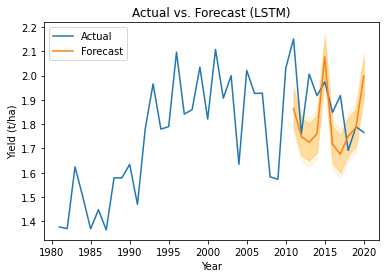

In [234]:
#Actual vs. Forecast Plot
original = final_data[['Year', 'Yield']]
lower_ci_99 = df_forecast['Yield']-2.576*(np.std(final_pred)/np.sqrt(10))
upper_ci_99 = df_forecast['Yield']+2.576*(np.std(final_pred)/np.sqrt(10))
lower_ci_95 = df_forecast['Yield']-1.96*(np.std(final_pred)/np.sqrt(10))
upper_ci_95 = df_forecast['Yield']+1.96*(np.std(final_pred)/np.sqrt(10))

sn.lineplot(original['Year'], original['Yield'],label='Actual').set(title='Actual vs. Forecast (LSTM)',ylabel='Yield (t/ha)')
sn.lineplot(df_forecast['Date'], df_forecast['Yield'],label='Forecast')
plt.fill_between(df_forecast['Date'], lower_ci_99, upper_ci_99, color='orange', alpha=.1)
plt.fill_between(df_forecast['Date'], lower_ci_95, upper_ci_95, color='orange', alpha=.3)
plt.legend(loc='upper left')
sn.lineplot()

In [235]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score

print('MAE: '+ str(mean_absolute_error(final_pred,actual_pred)))
print('RMSE: '+ str(np.sqrt(mean_squared_error(final_pred,actual_pred))))
print('MAPE: '+ str(mean_absolute_percentage_error(final_pred,actual_pred)))

MAE: 0.15063594655831303
RMSE: 0.18139692794399048
MAPE: 0.08341181298894472


# AutoKeras

In [ ]:
import autokeras as ak

In [ ]:
final_data.head()

,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT,Year
Year,,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143,1981
1982,1.500307,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190,1982
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916,1983
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922,1984
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531,1985


In [ ]:
val_split = int(len(final_data) * 0.7)
data_train = final_data[:val_split]
validation_data = final_data[val_split:]

In [ ]:
data_x=data_train[['AU','CS','CN','ES','MB','MN','RN','RS','SE','ST','SV','SW','WT']].astype('float64')
data_x_val=validation_data[['AU','CS','CN','ES','MB','MN','RN','RS','SE','ST','SV','SW','WT']].astype('float64')
data_x_test=final_data[['AU','CS','CN','ES','MB','MN','RN','RS','SE','ST','SV','SW','WT']].astype('float64')

data_y=data_train[['Yield']].astype('float64')
data_y_val=validation_data[['Yield']].astype('float64')

print(data_x.shape) 
print(data_y.shape)  

(28, 13)
(28, 1)


In [ ]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x,
    y=data_y,
    validation_data=(data_x_val, data_y_val),
    batch_size=72,
    epochs=100,
)
# Predict with the best model(includes original training data).
predictions = clf.predict(data_x_test)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(data_x_val, data_y_val))

Trial 1 Complete [00h 00m 11s]
val_loss: 3.3113675117492676

Best val_loss So Far: 3.3113675117492676
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 3.1070 - mean_squared_error: 3.1070 - val_loss: 3.9195 - val_mean_squared_error: 3.9195
Epoch 2/100
1/1 [==============================] - 0s 139ms/step - loss: 3.0862 - mean_squared_error: 3.0862 - val_loss: 3.9337 - val_mean_squared_error: 3.9337
Epoch 3/100
1/1 [==============================] - 0s 137ms/step - loss: 3.0652 - mean_squared_error: 3.0652 - val_loss: 3.9485 - val_mean_squared_error: 3.9485
Epoch 4/100
1/1 [==============================] - 0s 123ms/step - loss: 3.0440 - mean_squared_error: 3.0440 - val_loss: 3.9639 - val_mean_squared_error: 3.9639
Epoch 5/100
1/1 [==============================] - 0s 110ms/step - loss: 3.0226 - mean_squared_error: 3.0226 - val_loss: 3.9793 - val_mean_squared_error: 3.9793
Epoch 6/100
1/1 [=========

2022-05-13 00:53:20.536206: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


2/2 [==============================] - 0s 21ms/step
(9, 1)
1/1 [==============================] - 1s 1s/step - loss: 0.8845 - mean_squared_error: 0.8845
[0.8844712972640991, 0.8844712972640991]


In [ ]:
#Predicted Year
df_forecast = pd.DataFrame({'Date':np.arange(start=2018-len(predictions), stop=2018, step=1), 'Yield':predictions.flatten()})
df_forecast

,Date,Yield
0,2009,1.506171
1,2010,2.118176
2,2011,2.398314
3,2012,2.548802
4,2013,2.965831
5,2014,3.159941
6,2015,3.041525
7,2016,3.115644
8,2017,3.018960


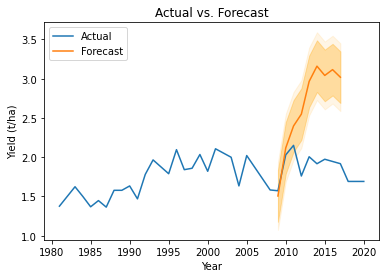

In [ ]:
#Actual vs. Forecast Plot
original = final_data[['Year', 'Yield']]
lower_ci_99 = df_forecast['Yield']-2.576*(np.std(predictions)/np.sqrt(10))
upper_ci_99 = df_forecast['Yield']+2.576*(np.std(predictions)/np.sqrt(10))
lower_ci_95 = df_forecast['Yield']-1.96*(np.std(predictions)/np.sqrt(10))
upper_ci_95 = df_forecast['Yield']+1.96*(np.std(predictions)/np.sqrt(10))

sn.lineplot(original['Year'], original['Yield'],label='Actual').set(title='Actual vs. Forecast',ylabel='Yield (t/ha)')
sn.lineplot(df_forecast['Date'], df_forecast['Yield'],label='Forecast')
plt.fill_between(df_forecast['Date'], lower_ci_99, upper_ci_99, color='orange', alpha=.1)
plt.fill_between(df_forecast['Date'], lower_ci_95, upper_ci_95, color='orange', alpha=.3)
plt.legend(loc='upper left')
sn.lineplot()